### Authors:

Marek Szydłowski 136633<br>
Wojciech Tomczak 145467

Link to the source code: https://github.com/Vosloo/EC_LABS/tree/master/lab_1

In [1]:
from copy import deepcopy
from dataclasses import dataclass
from random import choice, sample
from statistics import mean
from time import perf_counter
from typing import Callable

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

plt.rcParams['figure.figsize'] = (16, 12)
sns.set_theme(style="darkgrid")


In [2]:
df_a = pd.read_csv("data/TSPA.csv", sep=";", header=None, names=["x", "y", "cost"])
df_b = pd.read_csv("data/TSPB.csv", sep=";", header=None, names=["x", "y", "cost"])


In [3]:
df_a

,x,y,cost
0,1510,353,84
1,3042,123,483
2,2145,389,1462
3,1030,365,1986
4,2125,360,145
...,...,...,...
195,1023,1258,197
196,3192,1271,1183
197,3735,1879,1461
198,3983,299,1309


In [4]:
df_b

,x,y,cost
0,2907,1115,928
1,3433,183,1864
2,2237,74,260
3,91,583,1006
4,3053,1867,993
...,...,...,...
195,1252,970,1882
196,613,784,439
197,3139,470,597
198,2465,1165,570


# Problem:
 1. Select 50% of nodes and form a Hamiltonian cycle.
 2. The sum of the total length of the path plus the total cost of the selected nodes should be minimized.

In [5]:
class Node:
    def __init__(self, id, x, y, cost) -> None:
        self.id = id
        self.x = x
        self.y = y
        self.cost = cost
        self.connections: list[Node] = []

    def add_connection(self, node: "Node") -> None:
        self.connections.append(node)
        node.connections.append(self)

    def remove_connection(self, node: "Node") -> None:
        self.connections.remove(node)
        node.connections.remove(self)

    def __eq__(self, o: object) -> bool:
        if isinstance(o, Node):
            return self.id == o.id

        return False
    
    def __hash__(self) -> int:
        return self.id

    def __repr__(self) -> str:
        return str(self.id)

    def __str__(self) -> str:
        return str(self.id)

In [6]:
def _euclidean_distance(a: Node, b: Node) -> float:
    return round(((a.x - b.x) ** 2 + (a.y - b.y) ** 2) ** 0.5)

```
algorithm random is
    input: Pivot node pn,
           List of nodes N,
           Number of nodes to select k
    output: Selected nodes S

    
    S := k - 1 randomly selected nodes from N
    S := S + pn

    return S 
```

In [7]:
def random(pivot_node: Node, nodes: list[Node], k: int, distance_matrix) -> list[Node]:
    return sample(nodes, k)
    

```
algorithm nearest is
    input: Pivot node pn,
           List of nodes N,
           Number of nodes to select k
    output: Selected nodes S

    S := [pn]

    for i := 0 to k - 1
        m_dst := inf
        m_n := nothing

        c_n := S[-1]

        for n in N
            if n in S
                continue
            
            dst := dst_matrix[c_n][n]

            if dst < m_dst
                m_dst := dst
                m_n := n

        S := S + m_n
    
    return S
```

In [8]:
def _get_distance_matrix(nodes: list[Node]) -> list[list[float]]:
    distance_matrix = []

    for pivot_node in nodes:
        distance_matrix.append([_euclidean_distance(pivot_node, node) for node in nodes])

    return distance_matrix


def _get_nearest_node(pivot_node: Node, unselected_nodes: list[Node], distance_matrix) -> Node:
    min_distance = float("inf")
    min_node = None
    for node in unselected_nodes:
        distance = distance_matrix[pivot_node.id][node.id] + node.cost

        if distance < min_distance:
            min_distance = distance
            min_node = node

    return min_node


def nearest(pivot_node: Node, nodes: list[Node], k: int, distance_matrix) -> list[Node]:
    nodes_set = set(nodes)
    selected_nodes = [pivot_node]
    
    for _ in range(k - 1):
        cur_node = selected_nodes[-1]
        unselected_nodes = nodes_set - set(selected_nodes)

        min_node = _get_nearest_node(cur_node, unselected_nodes, distance_matrix)

        selected_nodes.append(min_node)

    return selected_nodes


```
algorithm greedy is
    input: Pivot node pn,
           List of nodes N,
           Number of nodes to select k
    output: Selected nodes S

    S := [pn]
    m_n := nearest neighbour of pn (based on score)
    
    S := S + m_n

    for i := 0 in k - 2
        m_dst := inf
        m_n := nothing
        edges := list of edges in S

        PN := N - S

        for node in PN
            for edge in edges
                dst := distance delta when reconnecting node to edge

                if dst < m_dst
                    m_dst := dst
                    m_n := node

    S := S + m_n
    
    return S
```

In [9]:
def _get_edges(selected_nodes: list[Node]) -> list[tuple[Node, Node]]:
    edges = []
    visited_nodes = set()
    for selected_node in selected_nodes:
        for connection in selected_node.connections:
            if connection not in visited_nodes:
                edges.append((selected_node, connection))

        visited_nodes.add(selected_node)

    return edges


def _nodes_to_seq(nodes: list[Node]) -> list[Node]:
    cur_node = nodes[0]        
    seq = [cur_node]
    while True:
        
        for connection in cur_node.connections:
            if connection in seq:
                continue

            seq.append(connection)
            cur_node = connection
            break

        if len(seq) == len(nodes):
            break

    return seq


def greedy(pivot_node: Node, nodes: list[Node], k: int, distance_matrix) -> list[Node]:
    nodes_set = set(nodes)

    selected_nodes = [pivot_node]
    min_node = _get_nearest_node(pivot_node, set(nodes) - set(selected_nodes), distance_matrix)

    pivot_node.add_connection(min_node)
    selected_nodes.append(min_node)

    anchor_nodes = []
    for _ in range(k - 2):
        min_distance = float("inf")
        min_node = None
        edges = _get_edges(selected_nodes)
        
        possible_nodes = nodes_set - set(selected_nodes)
        for node in possible_nodes:
            for edge in edges:
                anchor_1, anchor_2 = edge
                distance = (
                    distance_matrix[anchor_1.id][node.id]
                    + distance_matrix[anchor_2.id][node.id]
                    + node.cost
                    - distance_matrix[anchor_1.id][anchor_2.id]
                )

                if distance < min_distance:
                    min_distance = distance
                    min_node = node
                    anchor_nodes = [anchor_1, anchor_2]
                
        anchor_1, anchor_2 = anchor_nodes
        if len(selected_nodes) > 2:
            anchor_1.remove_connection(anchor_2)

        anchor_1.add_connection(min_node)
        anchor_2.add_connection(min_node)

        selected_nodes.append(min_node)

    return _nodes_to_seq(selected_nodes)

In [10]:
@dataclass
class Run:
    def __init__(self, id: int, nodes: list[Node], cost: int, distance: int) -> None:
        self.id: int = id
        self.nodes: list[Node] = nodes
        self.cost: int = cost
        self.distance: int = distance

    @property
    def score(self) -> int:
        return self.cost + self.distance

    def __repr__(self) -> str:
        return f"Run(id={self.id}, cost={self.cost}, distance={self.distance})"


@dataclass
class Grade:
    def __init__(self, method_name: str, best_run: Run, runs: list[Run]) -> None:  #res: list[tuple[int, int]]
        self.method_name = method_name
        self.best_run: Run = best_run
        self.runs = runs

        scores = [run.score for run in runs]
        self.min: float = min(scores)
        self.max: float = max(scores)
        self.avg: float = mean(scores)

    def __repr__(self) -> str:
        return (
            f"\n{' Grade ':=^80}"
            f"\n{'Method:':<40}{self.method_name}"
            f"\n{'Best run id:':<40}{self.best_run.id}"
            f"\n{'Best run cost:':<40}{self.best_run.cost}"
            f"\n{'Best run distance:':<40}{self.best_run.distance}"
            f"\n{'Best run score:':<40}{self.best_run.score}"
            f"\n{'Min score:':<40}{self.min}"
            f"\n{'Avg score:':<40}{self.avg}"
            f"\n{'Max score:':<40}{self.max}"
            f"\n{'':=^80}\n"
        )


In [11]:
def grade_method(og_nodes: list[Node], method: Callable, no_runs: int, distance_matrix) -> Grade:
    runs = []
    best_run = None
    best_run_score = float("inf")

    for pivot_ind in range(no_runs):
        print(f"\r{pivot_ind + 1:3} / {no_runs:3}", end="")
        nodes_cp = deepcopy(og_nodes)
        pivot_node = nodes_cp[pivot_ind]

        selected_nodes = method(pivot_node, nodes_cp, round(len(nodes_cp) / 2), distance_matrix)

        total_cost = sum(node.cost for node in selected_nodes)
        total_distance = sum(
            _euclidean_distance(selected_nodes[i], selected_nodes[i + 1])
            for i in range(len(selected_nodes) - 1)
        ) + _euclidean_distance(selected_nodes[-1], selected_nodes[0])

        curr_run = Run(pivot_ind, selected_nodes, total_cost, total_distance)
        runs.append(curr_run)

        if best_run_score > curr_run.score:
            best_run = Run(pivot_ind, selected_nodes, total_cost, total_distance)
            best_run_score = curr_run.score
    
    return Grade(method.__name__, best_run, runs)

In [12]:
def hex_to_RGB(hex: str) -> list[int]:
    return [int(hex[i : i + 2], 16) for i in range(1, 6, 2)]


def RGB_to_hex(RGB: list[int]) -> str:
    RGB = [int(x) for x in RGB]
    return "#" + "".join(["0{0:x}".format(v) if v < 16 else "{0:x}".format(v) for v in RGB])


def create_linear_gradient(
    start_hex: str = "#FF0000", end_hex: str = "#00FF00", n: int = 10
) -> list[str]:
    s = hex_to_RGB(start_hex)
    f = hex_to_RGB(end_hex)
    gradient = [start_hex]
    for t in range(1, n):
        curr_vector = [int(s[j] + (float(t) / (n - 1)) * (f[j] - s[j])) for j in range(3)]
        gradient.append(RGB_to_hex(curr_vector))

    return gradient


def map_linear_gradient(nodes: list[Node]) -> list[str]:
    min_cost = min(nodes, key=lambda x: x.cost).cost
    gradient = create_linear_gradient(start_hex="#C6EA8D", end_hex="#FE90AF", n=max(nodes, key=lambda x: x.cost).cost - min_cost + 1)

    return [gradient[node.cost - min_cost] for node in nodes]


In [13]:
def visualise_solution(nodes: list[Node], method_name: str) -> None:
    G = nx.Graph()

    for node in nodes:
        G.add_node(node, pos=(node.x, node.y), size=node.cost)
    
    for i in range(len(nodes) - 1):
        G.add_edge(nodes[i], nodes[i + 1])
    
    G.add_edge(nodes[-1], nodes[0])

    pos = nx.get_node_attributes(G, 'pos')

    # Add node colors from gradient adding legend
    node_colors = map_linear_gradient(nodes)

    # Normalize node sizes from 200 to 1000
    node_sizes = [node.cost for node in nodes]
    node_sizes = [200 + (1000 - 200) * ((node_size - min(node_sizes)) / (max(node_sizes) - min(node_sizes))) for node_size in node_sizes]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

    plt.title(f"{method_name.capitalize()} method")
    plt.show()


In [14]:
def plot_grades(grades: list[Grade]) -> None:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

    for method_name, grade in grades.items():
        ax1.plot([run.id for run in grade.runs], [run.cost for run in grade.runs], label=method_name)
        ax2.plot([run.id for run in grade.runs], [run.distance for run in grade.runs], label=method_name)
        ax3.plot([run.id for run in grade.runs], [run.cost + run.distance for run in grade.runs], label=method_name)

        ax1.scatter(grade.best_run.id, grade.best_run.cost, color=ax1.lines[-1].get_color(), label=f"{method_name} best run")
        ax2.scatter(grade.best_run.id, grade.best_run.distance, color=ax2.lines[-1].get_color(), label=f"{method_name} best run")
        ax3.scatter(grade.best_run.id, grade.best_run.cost + grade.best_run.distance, color=ax3.lines[-1].get_color(), label=f"{method_name} best run")

    ax1.set_title("Cost")
    ax2.set_title("Distance")
    ax3.set_title("Score")

    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.show()


def grade_dataset(df: pd.DataFrame):
    nodes = [Node(i, x, y, cost) for i, (x, y, cost) in enumerate(zip(df.x, df.y, df.cost))]

    distance_matrix = _get_distance_matrix(nodes)

    grades: dict[str, Grade] = {}
    no_runs = len(nodes)

    for method in [random, nearest, greedy]:
        method_name = method.__name__
        print(f"Running {method_name} method for {no_runs} runs")
        start = perf_counter()
        grades[method_name] = grade_method(nodes, method, no_runs, distance_matrix)
        print(f"\rFinished {method_name} method in {perf_counter() - start:.2f}s")

    for method_name, grade in grades.items():
        print(grade)

    for method_name, grade in grades.items():
        visualise_solution(grade.best_run.nodes, method_name)

    plot_grades(grades)


# Dataset TSPA

Running random method for 200 runs
Finished random method in 0.27s
Running nearest method for 200 runs
Finished nearest method in 0.72s
Running greedy method for 200 runs
Finished greedy method in 35.14s

==================================== Grade =====================================
Method:                                 random
Best run id:                            182
Best run cost:                          86144
Best run distance:                      153782
Best run score:                         239926
Min score:                              239926
Avg score:                              266069.15
Max score:                              287011


==================================== Grade =====================================
Method:                                 nearest
Best run id:                            1
Best run cost:                          51792
Best run distance:                      32679
Best run score:                         84471
Min score:                  

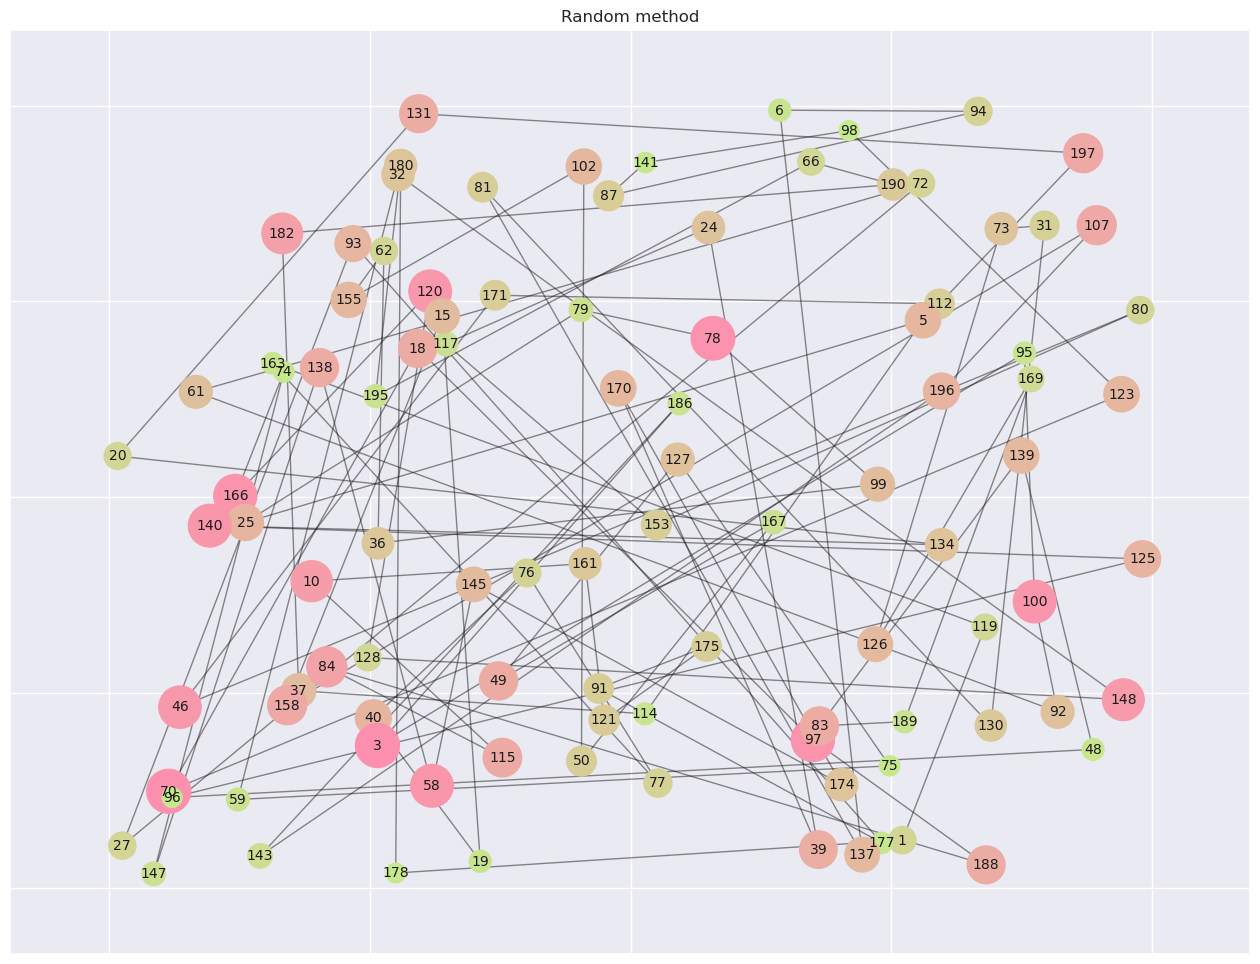

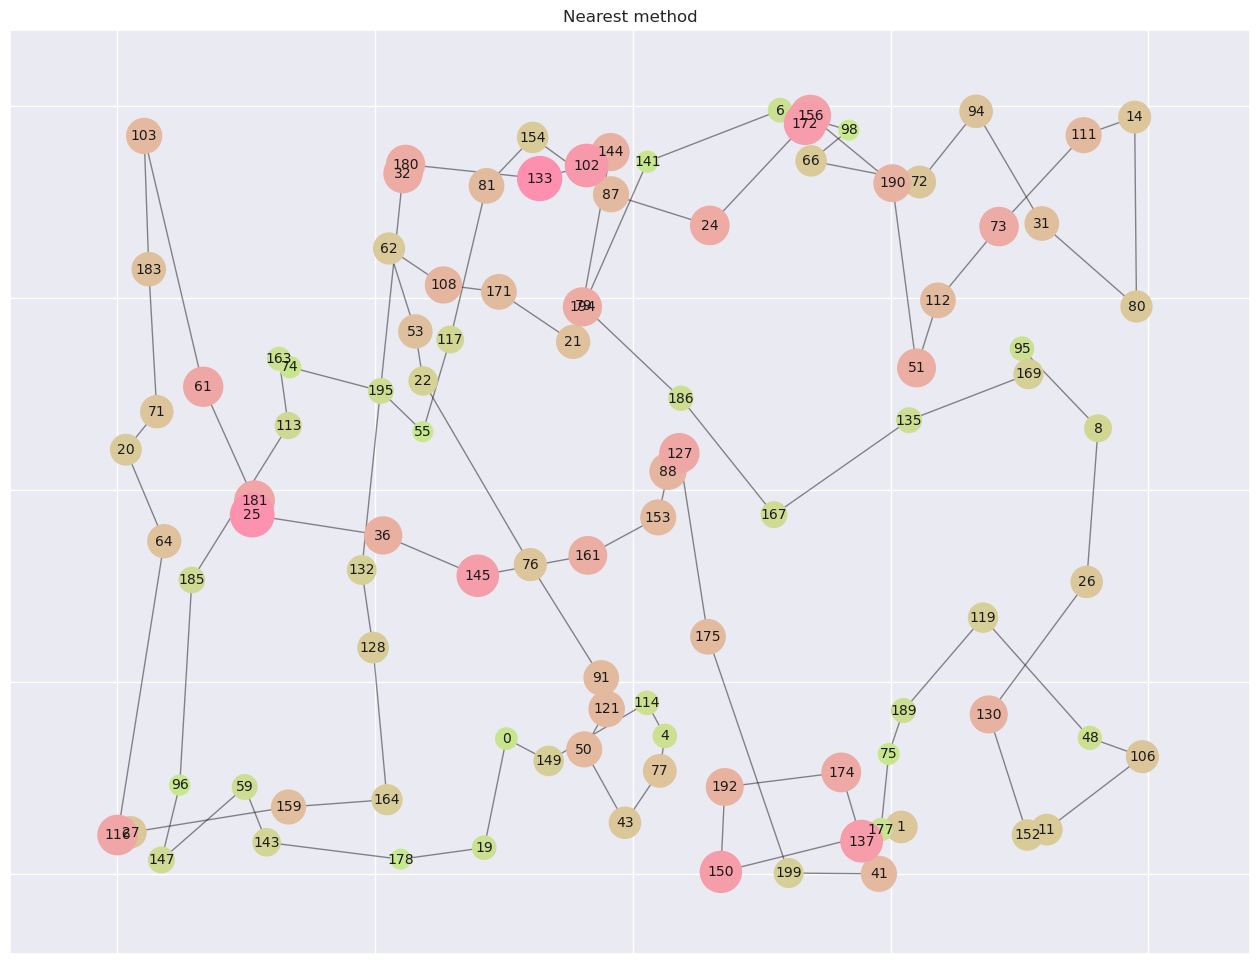

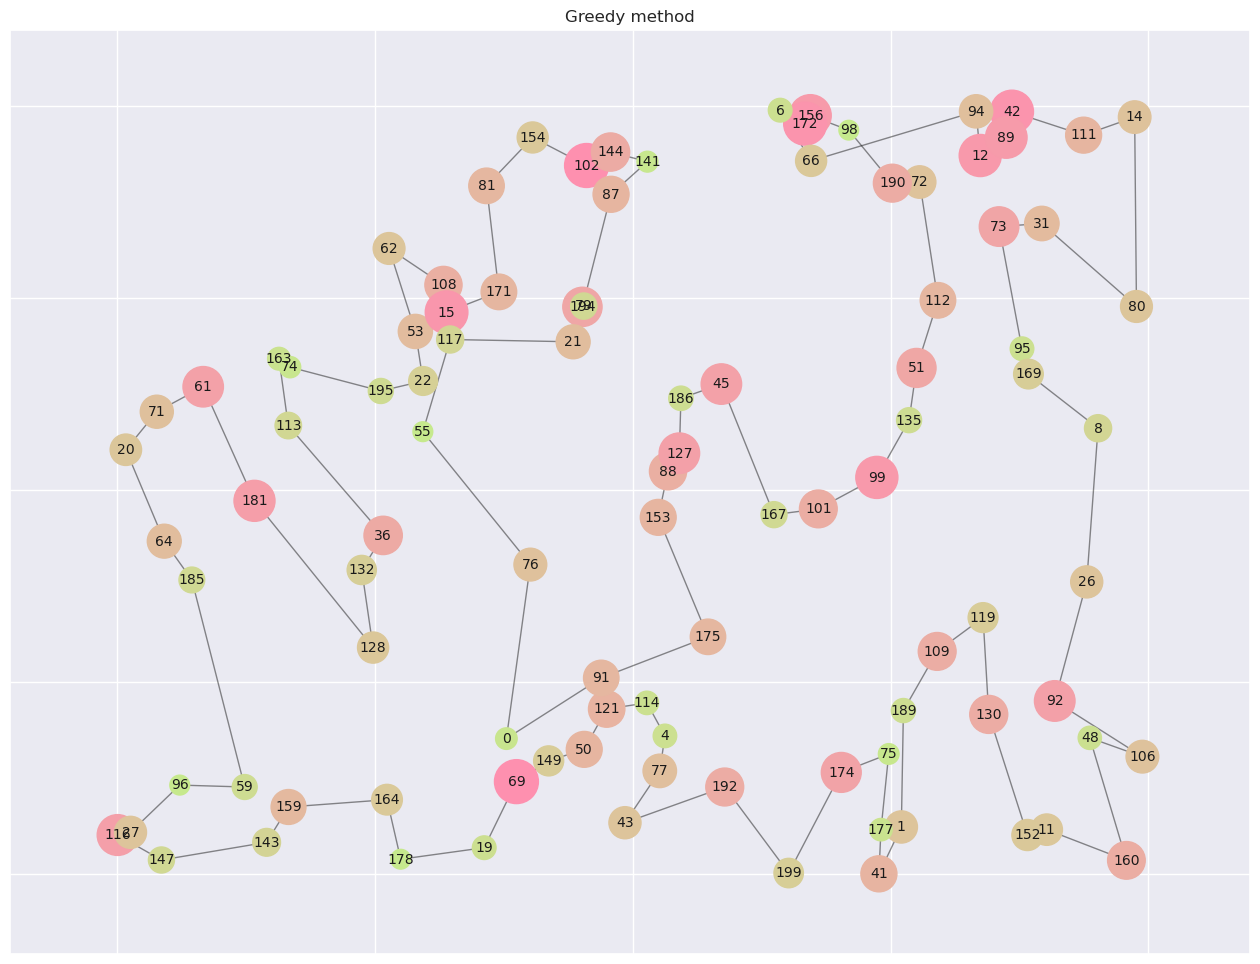

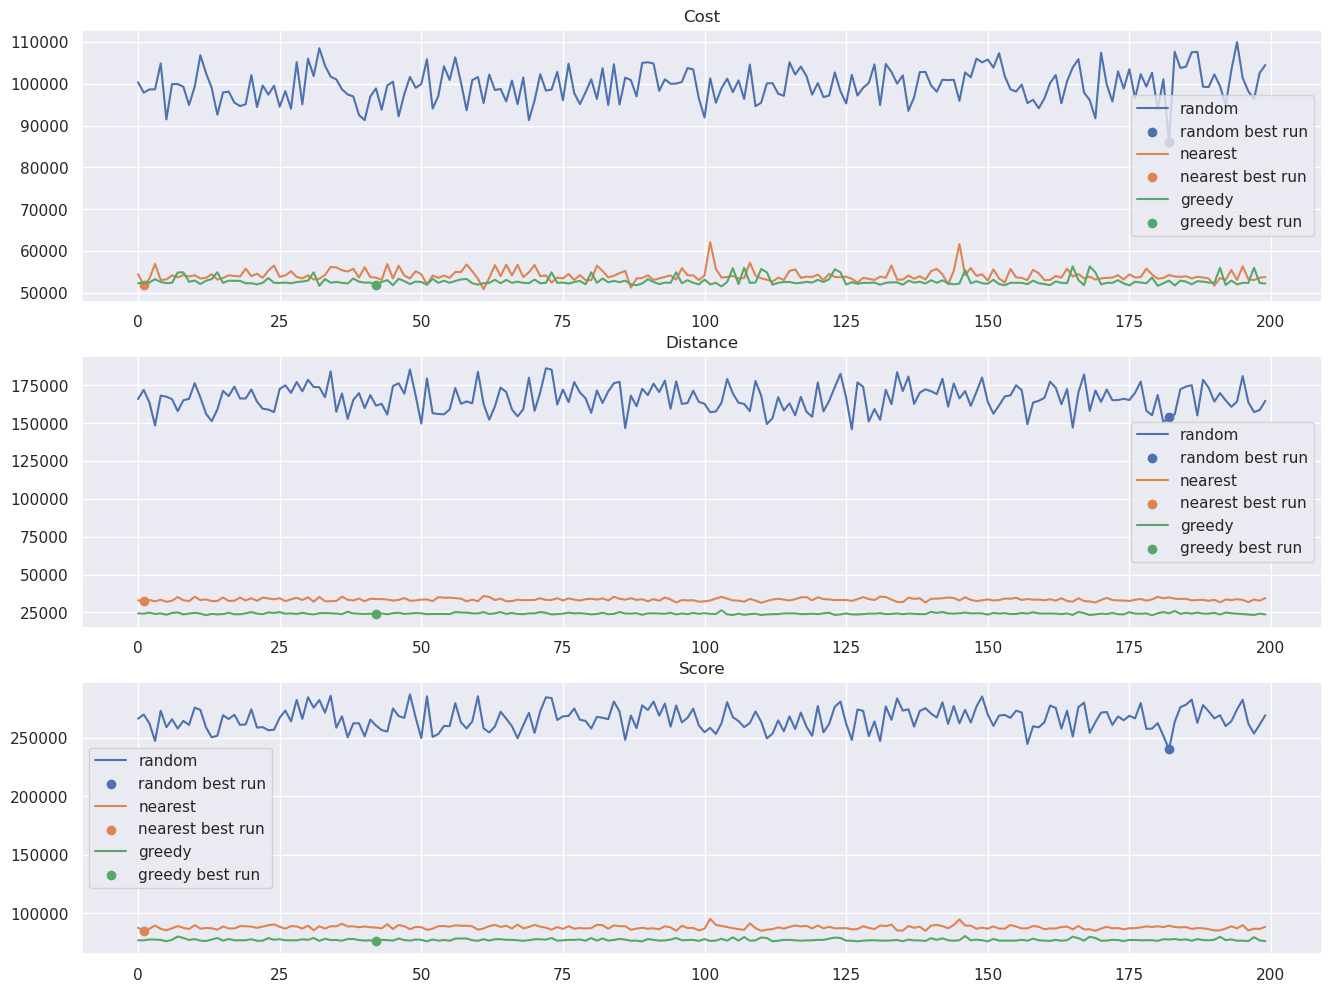

In [15]:
grade_dataset(df_a)

# Dataset TSPB

Running random method for 200 runs
Finished random method in 0.39s
Running nearest method for 200 runs
Finished nearest method in 0.73s
Running greedy method for 200 runs
Finished greedy method in 35.15s

==================================== Grade =====================================
Method:                                 random
Best run id:                            14
Best run cost:                          96096
Best run distance:                      145353
Best run score:                         241449
Min score:                              241449
Avg score:                              266261.575
Max score:                              297162


==================================== Grade =====================================
Method:                                 nearest
Best run id:                            63
Best run cost:                          46635
Best run distance:                      30813
Best run score:                         77448
Min score:                 

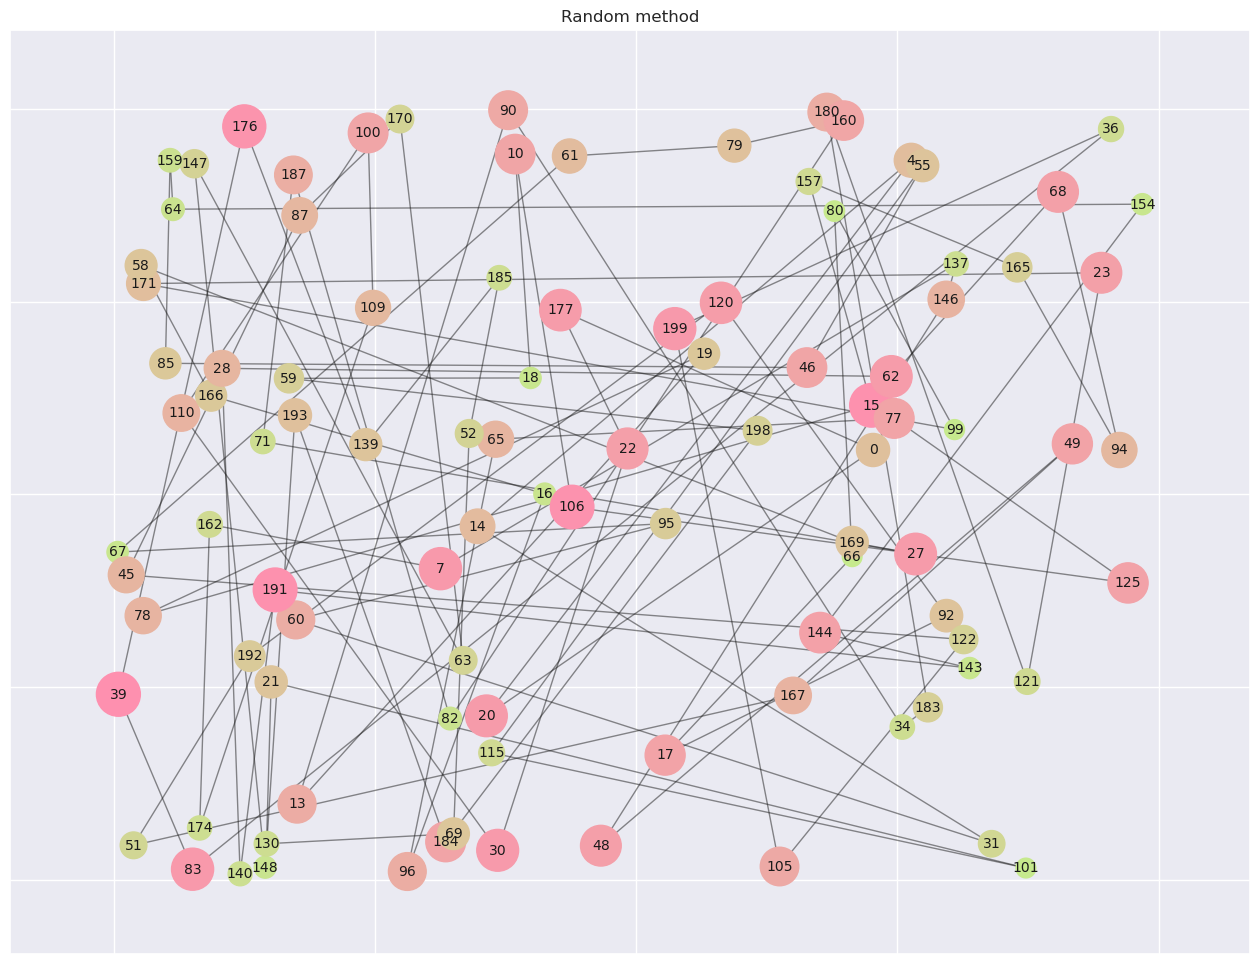

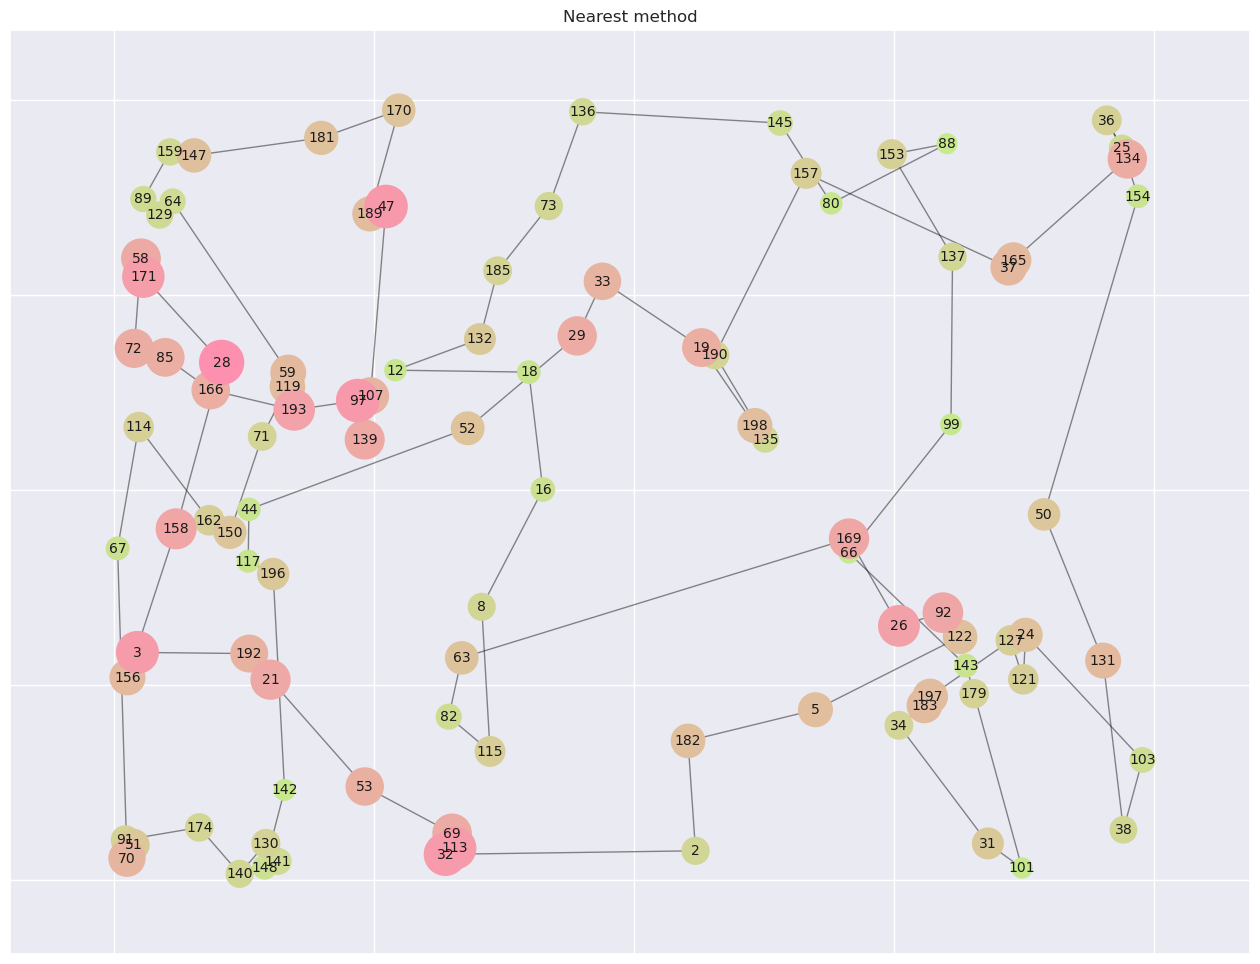

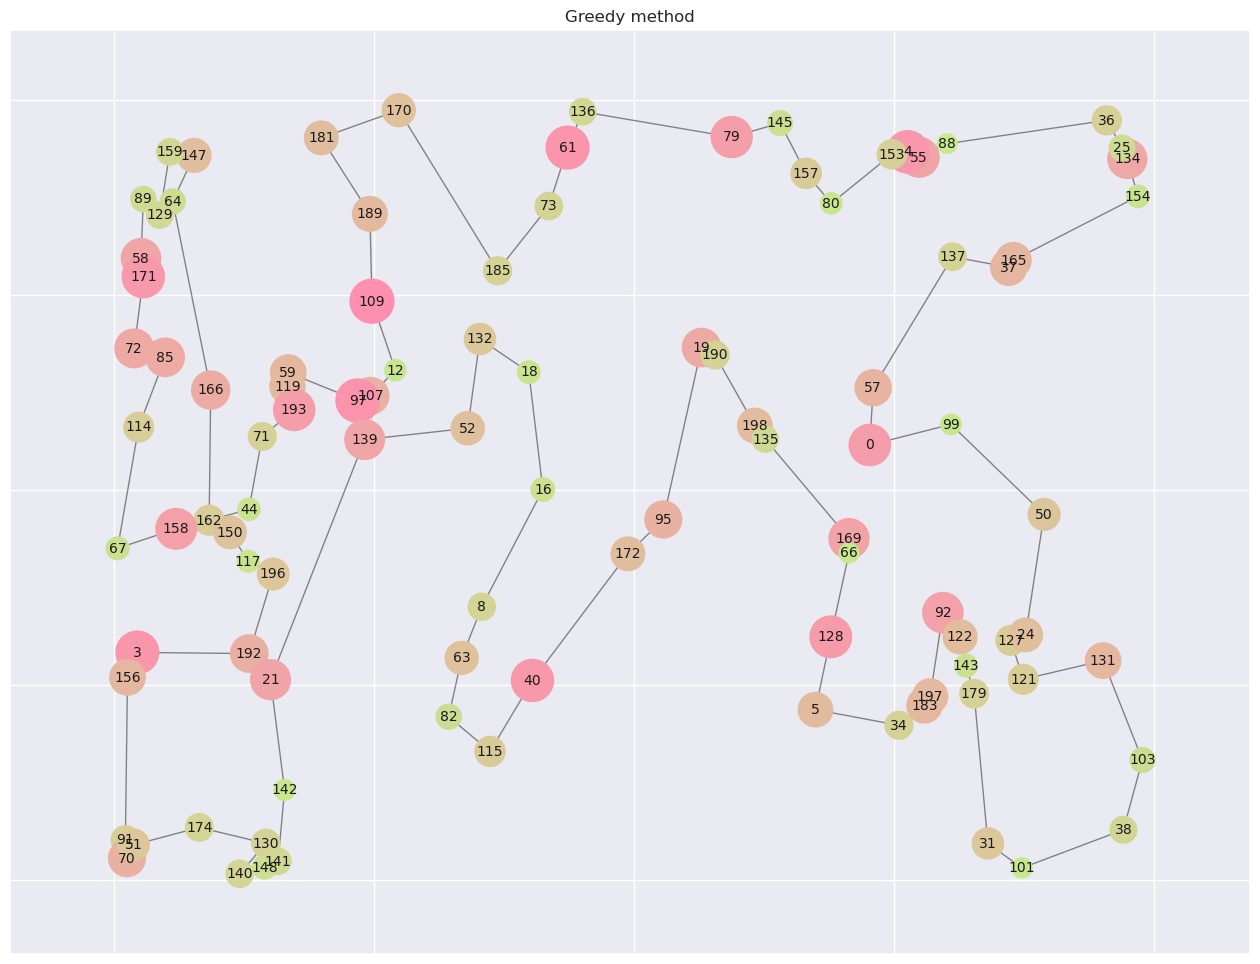

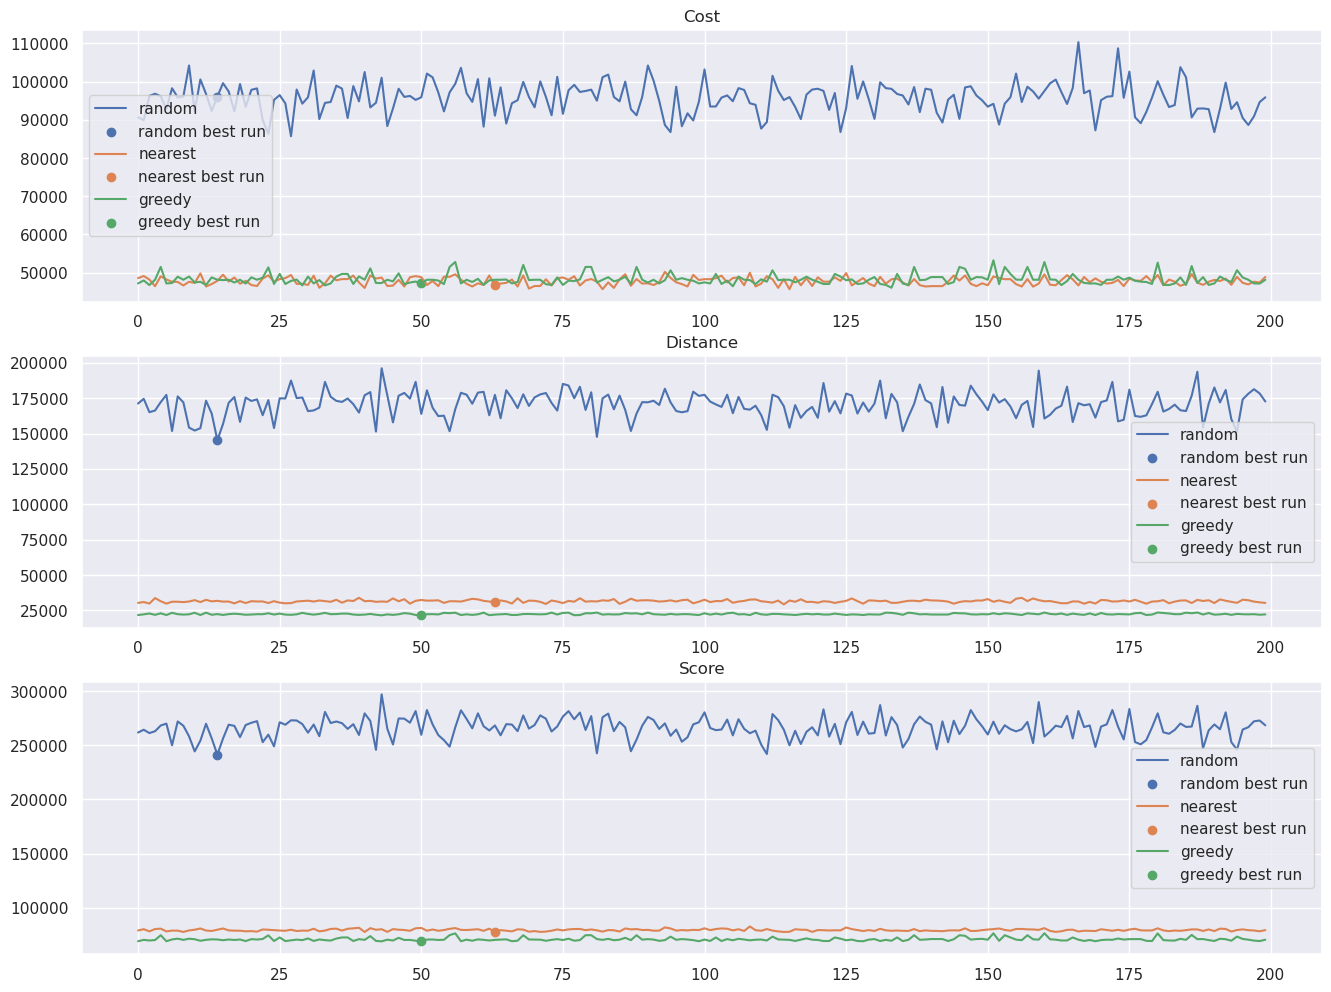

In [16]:
grade_dataset(df_b)

As we can see from aforementioned graphs and tables the greedy method for both datasets (TSPA and TSPB) has the best score out of three approaches. The random one is the worst one (which was kind of obvious). The nearest neighbour method is the second best one - with the overall score not much worse than the greedy one although with much better runtime.